## Let's see the data

### Garbage in garbage out
Data is coming from scraping, and it is changing so rapidly, needs to be careful

**Collections in Database**
* video_detail : contains title, url, published date, video_id of video
* view_count : contains # of views, comments, likes
* comments : contatins comments for video

In [1]:
# Import prerequsities
import pandas as pd
import numpy as np
import time

from matplotlib import pyplot as plt
from matplotlib import dates as mdates
from pymongo import MongoClient
from datetime import datetime

In [2]:
# connect mongodb through ssh tunnel
connection = MongoClient(port=47017)
db = connection['youtube_scrap']

### Video Detail

#### contains basic information of video
* title
* url
* published date

In [3]:
def get_all_collection(coll, filters=None):
    """Returns the list of objects in mongodb collection"""
    cursor = coll.find({})
    results = [obj for obj in cursor]
    return results
    

In [4]:
video_coll = db['video_detail']

In [5]:
videos = get_all_collection(video_coll)

In [6]:
len(videos)

268

In [7]:
videos[0]

{'_id': ObjectId('5d13aed7e70a248460e5833f'),
 'video_id': 'YBnGBb1wg98',
 'title': "Red Velvet 레드벨벳 '짐살라빔 (Zimzalabim)' MV",
 'url': 'https://www.youtube.com/watch?v=YBnGBb1wg98',
 'published': 'Premiered Jun 19, 2019'}

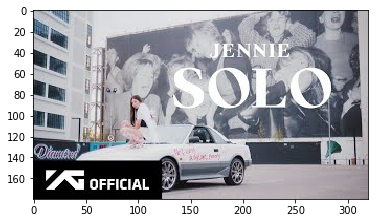

In [8]:
# Get thumbnail image from yotube
from simshow import simshow

# Check with one video
video = videos[7]
url = f'http://img.youtube.com/vi/{video["video_id"]}/mqdefault.jpg'
simshow(url)

#### put it into dataframe

In [9]:
video_df = pd.DataFrame(videos)
video_df.head()

,_id,published,title,url,video_id
0,5d13aed7e70a248460e5833f,"Premiered Jun 19, 2019",Red Velvet 레드벨벳 '짐살라빔 (Zimzalabim)' MV,https://www.youtube.com/watch?v=YBnGBb1wg98,YBnGBb1wg98
1,5d13aedee70a248460e58340,"Premiered Apr 4, 2019",BLACKPINK - 'Kill This Love' M/V,https://www.youtube.com/watch?v=2S24-y0Ij3Y,2S24-y0Ij3Y
2,5d13aee5e70a248460e58341,"Published on Apr 12, 2019",BTS (방탄소년단) '작은 것들을 위한 시 (Boy With Luv) feat. ...,https://www.youtube.com/watch?v=XsX3ATc3FbA,XsX3ATc3FbA
3,5d13aeebe70a248460e58342,"Published on Jun 19, 2019","Stray Kids ""부작용(Side Effects)"" M/V",https://www.youtube.com/watch?v=5rPluw_-Eb4,5rPluw_-Eb4
4,5d13aef1e70a248460e58343,"Published on Jun 13, 2019",SOMI (전소미) - 'BIRTHDAY' M/V,https://www.youtube.com/watch?v=oDJ4ct59NC4,oDJ4ct59NC4


In [10]:
# Cleaning published date
video_df['published'] = [string.replace('Premiered', '') for string in video_df['published']]
video_df['published'] = [string.replace('Published', '') for string in video_df['published']]
video_df['published'] = [string.replace('on', '') for string in video_df['published']]

In [11]:
# convert it to datetime
video_df['published'] = pd.to_datetime(video_df['published'])

In [12]:
video_df['published'][0]

Timestamp('2019-06-19 00:00:00')

### Number of Published by Month

In [13]:
def show_by_month(by_date):
    """Draw a published by month chart"""

    # Set style for pyplot
    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(10, 6))
    fig.suptitle('Number of Published Video by Month')
    ax.bar(by_date.index, by_date)
    ax.set_xlabel('Year-Month')
    ax.set_ylabel('Count')
    plt.show()

In [14]:
# Add YearMonth column for group by
video_df['YearMonth'] = video_df['published'].apply(lambda x: 
                                                    '{year}-{month}'.format(year=x.year, 
                                                                            month=x.month))


In [15]:
published_by_month = video_df.groupby(['YearMonth'])['title'].nunique()

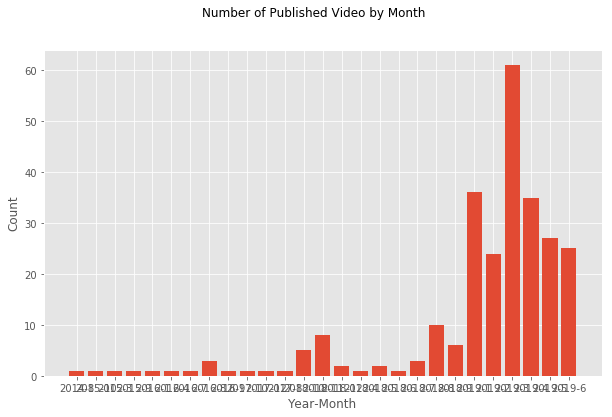

In [16]:
show_by_month(published_by_month)

#### Just focus on after 2019

In [17]:
after_2019 = video_df[video_df['published'] 
                   >= '2019-01-01'].groupby(['YearMonth'])['title'].nunique()


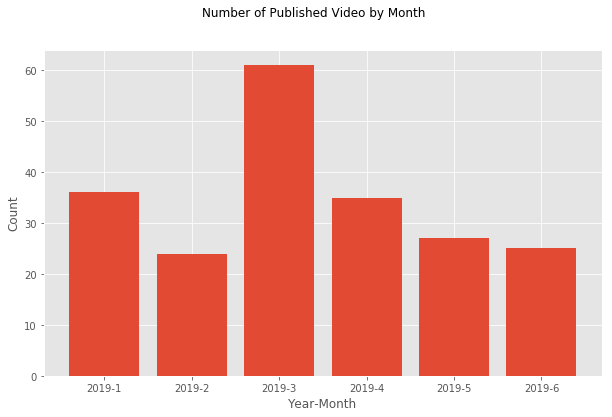

In [18]:
show_by_month(after_2019)

### View Count

#### contains performance of video at a moment
* video_id
* timestamp
* number of views, likes, and comments

In [19]:
view_count_coll = db['view_count']

In [20]:
view_counts = get_all_collection(view_count_coll)

In [21]:
# number of view_counts at now, it is increasing by scrapper
print(f'{datetime.now()} - {len(view_counts)}')
time.sleep(10)
view_counts = get_all_collection(view_count_coll)
print(f'{datetime.now()} - {len(view_counts)}')

2019-06-28 09:22:46.940209 - 14073
2019-06-28 09:22:57.338993 - 14075


In [22]:
view_count_df = pd.DataFrame(view_counts)

In [23]:
view_count_df.head()

,_id,comment_count,like_count,timestamp,title,video_id,view_count
0,5d13b6a99ec6103a9817d745,1530,25277,2019-06-26 18:17:09.330,모모랜드(MOMOLAND) - 바나나차차(뽀로로 삽입곡) M/V,kxdEoCDzm-k,502364
1,5d13b6b39ec6103a9817d746,583595,3508382,2019-06-26 18:17:19.652,EXO 엑소 'Love Shot' MV,pSudEWBAYRE,159871130
2,5d13b6bb9ec6103a9817d747,21557,244273,2019-06-26 18:17:27.695,A.C.E(에이스) - UNDER COVER M/V,qODWFe6v3zA,3169154
3,5d13b6c69ec6103a9817d748,2187,92749,2019-06-26 18:17:38.798,[MV] BOL4(볼빨간사춘기) _ Stars over me(별 보러 갈래?),8n9wklIG9qU,4289213
4,5d13b6cf9ec6103a9817d749,93467,1023889,2019-06-26 18:17:47.620,NCT 127 엔시티 127 'Simon Says' MV,arjy2v7zEI0,31832124


In [24]:
# Fix some missed data from scrapping

# cursor = view_count_coll.find({'video_id' : { '$exists': False}})

# for view in cursor:
#     video_id = video_df[video_df['title'] == view['title']]['video_id']

#     view_count_coll.update_one({"_id": view["_id"]},
#                                {"$set": {"video_id": video_id.values[0]}})


In [25]:
# View count for first video
view_count = view_count_df[view_count_df['video_id'] == video['video_id']]

In [26]:
view_count.sort_values(by='timestamp').head()


,_id,comment_count,like_count,timestamp,title,video_id,view_count
148,5d13bc379ec6103a9817d7d9,460909,5781099,2019-06-26 18:40:51.253,JENNIE - 'SOLO' M/V,b73BI9eUkjM,331503901
181,5d13bdc49ec6103a9817d7fa,460911,5781109,2019-06-26 18:47:28.424,JENNIE - 'SOLO' M/V,b73BI9eUkjM,331508719
425,5d13c6ba9ec6103a9817d8ee,460907,5781211,2019-06-26 19:25:42.282,JENNIE - 'SOLO' M/V,b73BI9eUkjM,331527799
640,5d13cf6b9ec6103a9817d9c5,460912,5781345,2019-06-26 20:02:47.040,JENNIE - 'SOLO' M/V,b73BI9eUkjM,331542175
708,5d13d2469ec6103a9817da09,460913,5781381,2019-06-26 20:14:58.291,JENNIE - 'SOLO' M/V,b73BI9eUkjM,331549621


#### Let's check scrapper is working

In [27]:
# register converters
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

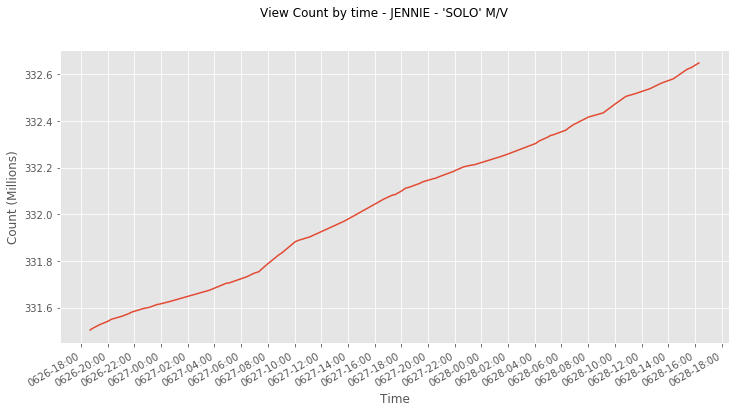

In [28]:
# See the changes by time
fig, ax = plt.subplots(figsize=(12, 6))
fig.suptitle(f'View Count by time - {video["title"]}')

ax.plot(view_count['timestamp'], 
        view_count['view_count'] / 1_000_000, 
        '-', 
        label='view')

hours = mdates.HourLocator(interval = 2)
h_fmt = mdates.DateFormatter('%m%d-%H:%M')

ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

ax.set_xlabel('Time')
ax.set_ylabel('Count (Millions)')

fig.autofmt_xdate()
plt.show()

### Check with the most recent data

In [29]:
# single video has a lot of view counts by time
# need to get max value by title (need to change to video_id)
# get group by value with mongodb's aggregate function
view_max_count =[row for row in view_count_coll.aggregate([
    {'$group' : {'_id':'$video_id', 
                 'view_count':{'$max':'$view_count'}, 
                 'like_count':{'$max':'$like_count'},
                 'comment_count':{'$max':'$comment_count'},
                }
    }
])]

In [30]:
view_count_df = pd.DataFrame(view_max_count)
view_count_df.columns=['video_id', 'comment_count', 'like_count', 'view_count']

In [31]:
view_count_df.head()

,video_id,comment_count,like_count,view_count
0,Nm7qzNNtnhI,16,70,421
1,5L8FXg8zbDA,12179,80120,2043924
2,DiChCQfS7u4,191,1989,8630
3,mLzNk_FfHjg,427,12974,875173
4,7KdWuQyIEYk,3121,42163,827020


In [32]:
len(view_count_df)

258

In [33]:
# Merge with video_detail
df = pd.merge(video_df, view_count_df, on='video_id')
df.head()

,_id,published,title,url,video_id,YearMonth,comment_count,like_count,view_count
0,5d13aed7e70a248460e5833f,2019-06-19,Red Velvet 레드벨벳 '짐살라빔 (Zimzalabim)' MV,https://www.youtube.com/watch?v=YBnGBb1wg98,YBnGBb1wg98,2019-6,168842,1633450,28895994
1,5d13aedee70a248460e58340,2019-04-04,BLACKPINK - 'Kill This Love' M/V,https://www.youtube.com/watch?v=2S24-y0Ij3Y,2S24-y0Ij3Y,2019-4,1420258,9097971,448460502
2,5d13aee5e70a248460e58341,2019-04-12,BTS (방탄소년단) '작은 것들을 위한 시 (Boy With Luv) feat. ...,https://www.youtube.com/watch?v=XsX3ATc3FbA,XsX3ATc3FbA,2019-4,3621857,11053259,417868454
3,5d13aeebe70a248460e58342,2019-06-19,"Stray Kids ""부작용(Side Effects)"" M/V",https://www.youtube.com/watch?v=5rPluw_-Eb4,5rPluw_-Eb4,2019-6,81961,810153,25959487
4,5d13aef1e70a248460e58343,2019-06-13,SOMI (전소미) - 'BIRTHDAY' M/V,https://www.youtube.com/watch?v=oDJ4ct59NC4,oDJ4ct59NC4,2019-6,88171,1608162,25071543


#### Check with histogram for the features

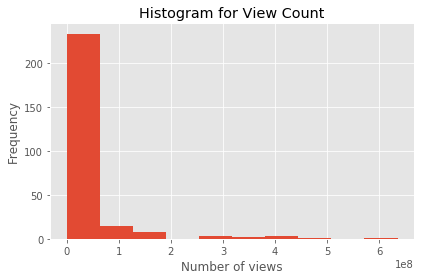

In [34]:
fig = df['view_count'].hist()
fig.set_xlabel('Number of views')
fig.set_ylabel('Frequency')
fig.set_title('Histogram for View Count')
plt.tight_layout()


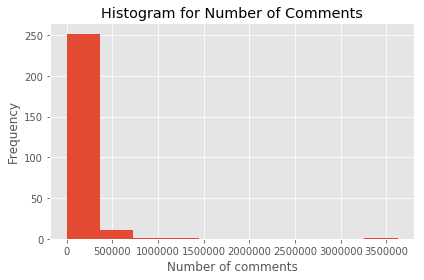

In [35]:
fig = df['comment_count'].hist();
fig.set_xlabel('Number of comments')
fig.set_ylabel('Frequency')
fig.set_title('Histogram for Number of Comments')
plt.tight_layout()

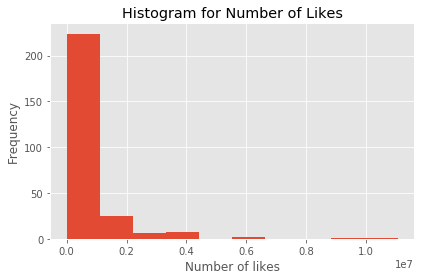

In [36]:
fig = df['like_count'].hist();
fig.set_xlabel('Number of likes')
fig.set_ylabel('Frequency')
fig.set_title('Histogram for Number of Likes')
plt.tight_layout()

### Comments

#### contains comments
* video_id
* comment text
* sentiment (probablity of positive)

In [37]:
comments_coll = db['comments']

In [38]:
comments = get_all_collection(comments_coll)

In [39]:
comments[0]

{'_id': ObjectId('5d13bbade70a248460e583ee'),
 'video_id': 'YBnGBb1wg98',
 'comment': "How many international fans are here ?\n\n\n\n\n\n\n\n\nI'm from the Philippines and currently live in America",
 'sentiment': 0.7865389082121107}

In [40]:
comments_df = pd.DataFrame(comments)

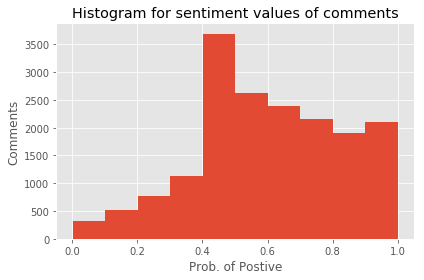

In [41]:
fig = comments_df['sentiment'].hist();
fig.set_xlabel('Prob. of Postive')
fig.set_ylabel('Comments')
fig.set_title('Histogram for sentiment values of comments')
plt.tight_layout()